In [11]:
#!pip install pytesseract
#!pip install --upgrade scikit-learn==0.22
#!pip install pdf2image
#!pip install PyPDF3

  Stored in directory: C:\Users\rames\AppData\Local\pip\Cache\wheels\96\b4\cb\39888a3c5c7986f06cf15e2fe5d804a2735c7b3962e9f3d736
Successfully built PyPDF3


In [33]:
import cv2
import pytesseract
from pytesseract import Output
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris

from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"


In [3]:
img = cv2.imread(r'C:\Users\rames\OneDrive\Documents\GitHub\Skill-Recommender-System\SampleResumes\01FB15ECS008-page-001.jpg')

d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(d.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


In [4]:
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 200:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2.imshow('img', img)
cv2.waitKey(0)

-1

In [34]:
import os
import tempfile
from pdf2image import convert_from_path
from PyPDF3 import PdfFileWriter, PdfFileReader

path="D:\College\FinalYearCapstone\StandardResume\\"
output_folder_path="D:\College\FinalYearCapstone\StandardResume\images\\"
pdfname=path+"01FB16ECS012_Copy_of_Resume_-_Abhinav_Hegde.pdf"


In [27]:

##   image = cv2.imread(args['image'])
##image = cv2.imread(r'D:\College\FinalYearCapstone\StandardResume\01FB16ECS012_Copy_of_Resume_-_Abhinav_Hegde.pdf')
#Saving a original image and shape

images = convert_from_path(pdfname,poppler_path = r"C:\Program Files\poppler-20.11.0\bin")
image = cv2.cvtColor(np.array(images[0]), cv2.COLOR_RGB2BGR)
orig = image.copy()
(origH, origW) = image.shape[:2]

# set the new height and width to default 320 by using args #dictionary.  
(newW, newH) = (320, 320)

#Calculate the ratio between original and new image for both height and weight. 
#This ratio will be used to translate bounding box location on the original image. 
rW = origW / float(newW)
rH = origH / float(newH)

# resize the original image to new dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

# construct a blob from the image to forward pass it to EAST model
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),(123.68, 116.78, 103.94), swapRB=True, crop=False)

In [30]:
layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]

# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(r'C:\Users\rames\OneDrive\Desktop\namma\FinalYear\frozen_east_text_detection.pb')
  
#Forward pass the blob from the image to get the desired output layers
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

# Returns a bounding box and probability score if it is more than minimum confidence
def predictions(prob_score, geo):
	(numR, numC) = prob_score.shape[2:4]
	boxes = []
	confidence_val = []

	# loop over rows
	for y in range(0, numR):
		scoresData = prob_score[0, 0, y]
		x0 = geo[0, 0, y]
		x1 = geo[0, 1, y]
		x2 = geo[0, 2, y]
		x3 = geo[0, 3, y]
		anglesData = geo[0, 4, y]

		# loop over the number of columns
		for i in range(0, numC):
			if scoresData[i] < 0.5:
				continue

			(offX, offY) = (i * 4.0, y * 4.0)

			# extracting the rotation angle for the prediction and computing the sine and cosine
			angle = anglesData[i]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# using the geo volume to get the dimensions of the bounding box
			h = x0[i] + x2[i]
			w = x1[i] + x3[i]

			# compute start and end for the text pred bbox
			endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
			endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
			startX = int(endX - w)
			startY = int(endY - h)

			boxes.append((startX, startY, endX, endY))
			confidence_val.append(scoresData[i])

	# return bounding boxes and associated confidence_val
	return (boxes, confidence_val)

[INFO] loading EAST text detector...


In [41]:
(boxes, confidence_val) = predictions(scores, geometry)
boxes = non_max_suppression(np.array(boxes), probs=confidence_val)
print(boxes)

##Text Detection and Recognition 

# initialize the list of results
results = []

# loop over the bounding boxes to find the coordinate of bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the coordinates based on the respective ratios in order to reflect bounding box on the original image
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	#extract the region of interest
	r = orig[startY:endY, startX:endX]

	#configuration setting to convert image to string.  
	custom_config = r'--oem 3 --psm 6'
text=pytesseract.image_to_string(r, config=custom_config)


results.append(((startX, startY, endX, endY), text))


[[143  40 167  53]
 [249 118 280 130]
 [163   7 195  18]
 [272  53 300  65]
 [124   5 169  18]
 [228 120 256 131]
 [203 287 235 297]
 [ 73  78 101  88]
 [257 287 295 297]
 [105  44 135  57]
 [143  20 173  32]
 [138 243 184 257]
 [170  39 195  50]
 [277  38 301  48]
 [265 210 303 220]
 [100  77 144  87]
 [222 219 242 229]
 [ 33 288  56 298]
 [186 220 209 233]
 [ 15  54  37  64]
 [ 85  44 109  54]
 [ 33 237  52 249]
 [ 12 150  38 160]
 [ 16  78  37  88]
 [173  53 193  64]]


94%




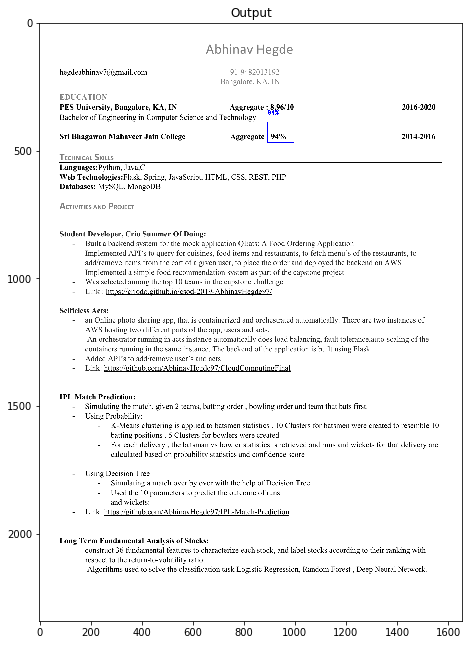

In [35]:
#Display the image with bounding box and recognized text
orig_image = orig.copy()

# Moving over the results and display on the image
for ((start_X, start_Y, end_X, end_Y), text) in results:
	# display the text detected by Tesseract
	print("{}\n".format(text))

	# Displaying text
	text = "".join([x if ord(x) < 128 else "" for x in text]).strip()
	cv2.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y),
		(0, 0, 255), 2)
	cv2.putText(orig_image, text, (start_X, start_Y - 30),
		cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0,0, 255), 2)

fig= plt.figure(figsize=(15,11))
plt.imshow(orig_image)
plt.title('Output')
plt.show()

In [34]:
boxes

array([[143,  40, 167,  53],
       [249, 118, 280, 130],
       [163,   7, 195,  18],
       [272,  53, 300,  65],
       [124,   5, 169,  18],
       [228, 120, 256, 131],
       [203, 287, 235, 297],
       [ 73,  78, 101,  88],
       [257, 287, 295, 297],
       [105,  44, 135,  57],
       [143,  20, 173,  32],
       [138, 243, 184, 257],
       [170,  39, 195,  50],
       [277,  38, 301,  48],
       [265, 210, 303, 220],
       [100,  77, 144,  87],
       [222, 219, 242, 229],
       [ 33, 288,  56, 298],
       [186, 220, 209, 233],
       [ 15,  54,  37,  64],
       [ 85,  44, 109,  54],
       [ 33, 237,  52, 249],
       [ 12, 150,  38, 160],
       [ 16,  78,  37,  88],
       [173,  53, 193,  64]])

In [36]:
img1_plot = orig_image.copy()

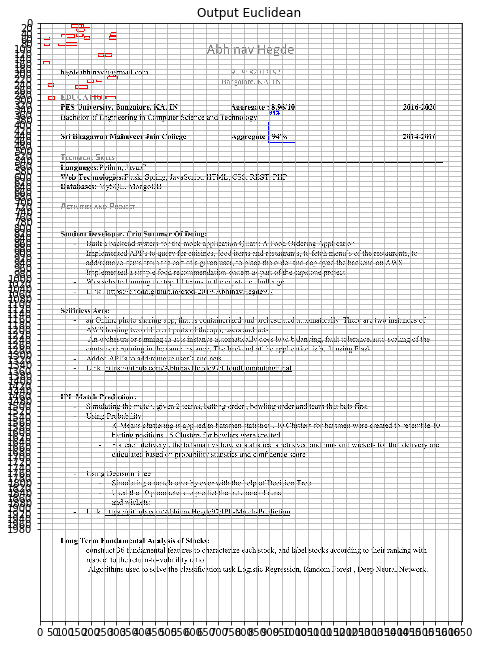

In [38]:
for box in boxes:
    cv2.rectangle(img1_plot, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),(255, 0, 0), 2)
fig= plt.figure(figsize=(15,11))
ax = fig.gca()
ax.set_xticks(np.arange(0, 1800, 50))
ax.set_yticks(np.arange(0, 2000, 20))
plt.imshow(img1_plot)
plt.title('Output Euclidean ')
plt.grid()
plt.show()

In [40]:
from shapely.geometry import point

OSError: [WinError 126] The specified module could not be found

In [4]:
text_file = open(r"C:\Users\rames\OneDrive\Desktop\namma\FinalYear\EAST-master\tmp\01FB16ECS012_Copy_of_Resume_-_Abhinav_Hegde-1.txt", "r")
lines = text_file.readlines()
print(len(lines))
print(type(lines[0]))
text_file.close()

664
<class 'str'>


In [11]:
vals =[]
for line in lines:
    coords = line.split(",")
    coords[-1]=coords[-1].rstrip('\n')
    if line=='\n':
        continue
    vals.append(coords)


In [14]:
import numpy as np
X = np.array(vals)

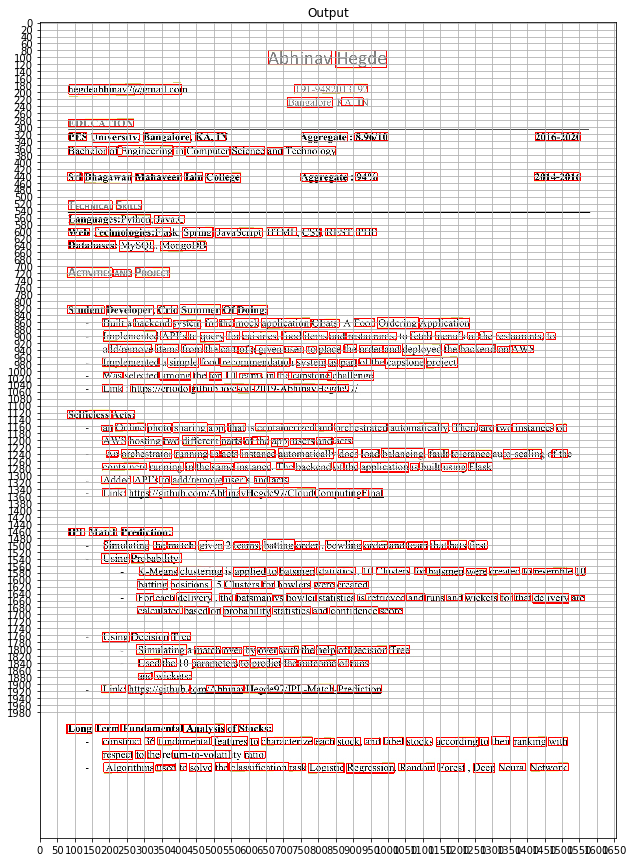

In [20]:
img1 = cv2.imread(r"C:\Users\rames\OneDrive\Desktop\namma\FinalYear\EAST-master\tmp\01FB16ECS012_Copy_of_Resume_-_Abhinav_Hegde-1.jpg")

img1_plot = img1.copy()
ctr = 0

# Moving over the results and display on the image
for row in X:
    cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[4]), int(row[5])),(255, 0, 0), 2)
  
    
fig= plt.figure(figsize=(20,15))
ax = fig.gca()
ax.set_xticks(np.arange(0, 1800, 50))
ax.set_yticks(np.arange(0, 2000, 20))
plt.imshow(img1_plot)
plt.title('Output')
plt.grid()
plt.show()



676
<class 'str'>


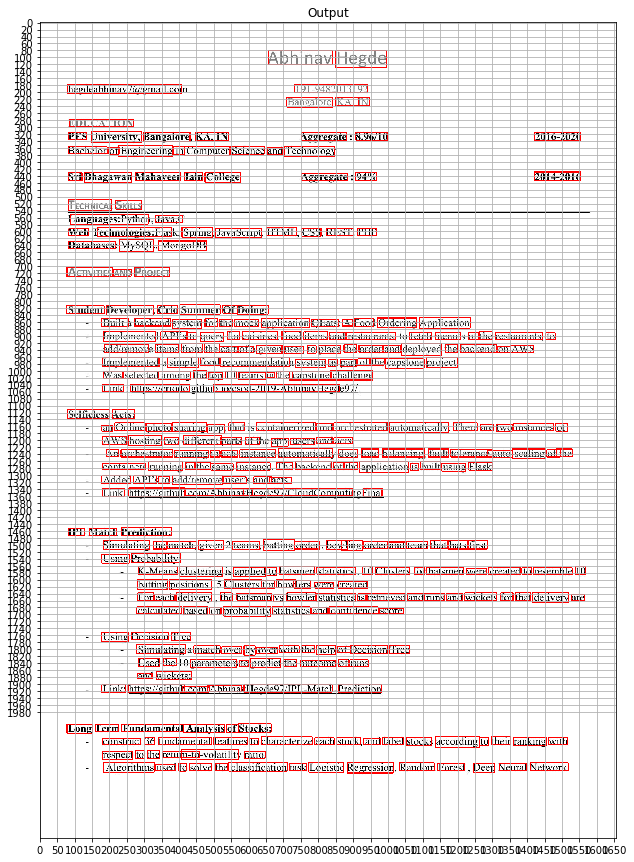

In [21]:
text_file = open(r"C:\Users\rames\OneDrive\Desktop\namma\FinalYear\EAST-master\tmp\output\output_0.txt", "r")
lines = text_file.readlines()
print(len(lines))
print(type(lines[0]))
text_file.close()

vals =[]
for line in lines:
    coords = line.split(",")
    coords[-1]=coords[-1].rstrip('\n')
    if line=='\n':
        continue
    vals.append(coords)
import numpy as np
X = np.array(vals)
img1 = cv2.imread(r"C:\Users\rames\OneDrive\Desktop\namma\FinalYear\EAST-master\tmp\images\output_0.jpg")

img1_plot = img1.copy()
ctr = 0

# Moving over the results and display on the image
for row in X:
    cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[4]), int(row[5])),(255, 0, 0), 2)
  
    
fig= plt.figure(figsize=(20,15))
ax = fig.gca()
ax.set_xticks(np.arange(0, 1800, 50))
ax.set_yticks(np.arange(0, 2000, 20))
plt.imshow(img1_plot)
plt.title('Output')
plt.grid()
plt.show()



788
<class 'str'>


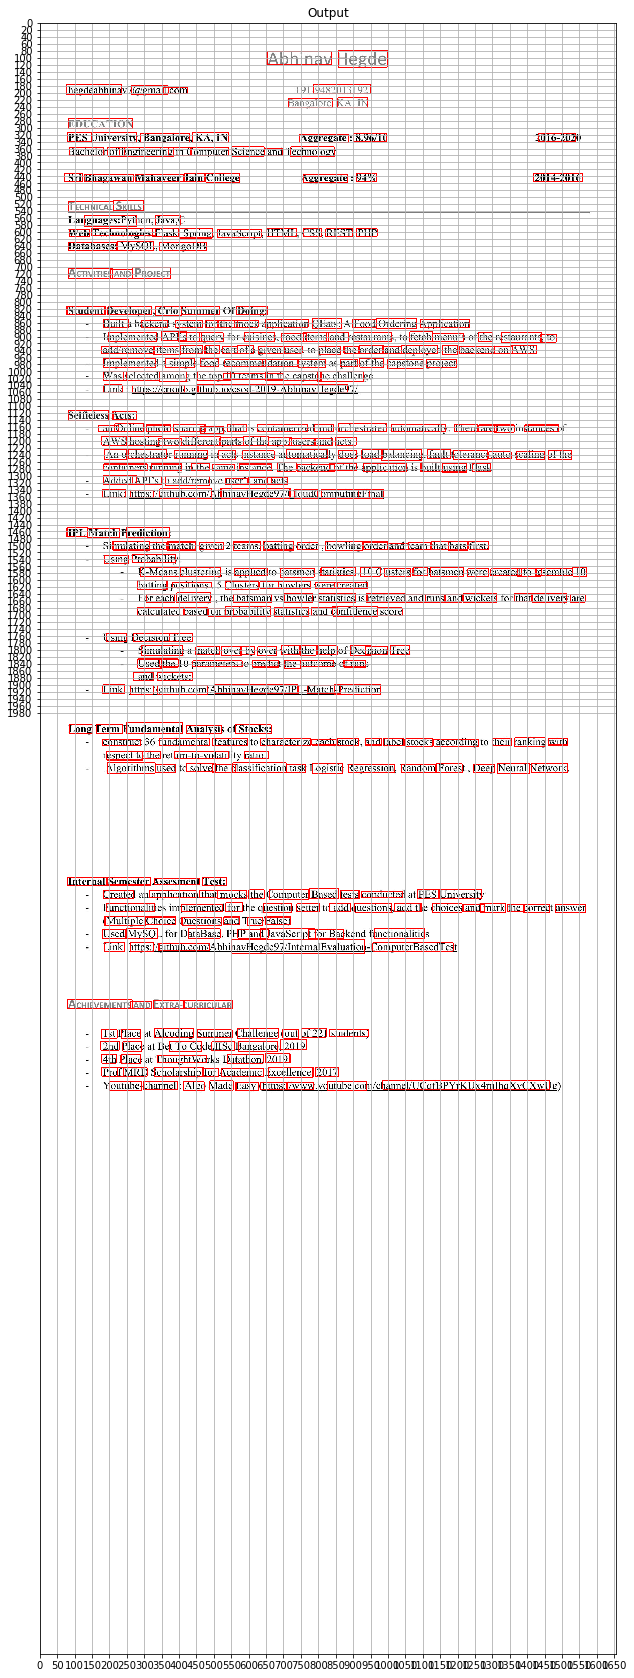

In [15]:
text_file = open(r"D:\College\FinalYearCapstone\StandardResume\coordinates\vertical.txt", "r")
lines = text_file.readlines()
print(len(lines))
print(type(lines[0]))
text_file.close()

vals =[]
for line in lines:
    coords = line.split(",")
    coords[-1]=coords[-1].rstrip('\n')
    if line=='\n':
        continue
    vals.append(coords)
import numpy as np
X = np.array(vals)
img1 = cv2.imread(r"D:\College\FinalYearCapstone\StandardResume\images\images1\vertical.jpg")

img1_plot = img1.copy()
ctr = 0

# Moving over the results and display on the image
for row in X:
    cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[4]), int(row[5])),(255, 0, 0), 2)
  
    
fig= plt.figure(figsize=(40,30))
ax = fig.gca()
ax.set_xticks(np.arange(0, 1800, 50))
ax.set_yticks(np.arange(0, 2000, 20))
plt.imshow(img1_plot)
plt.title('Output')
plt.grid()
plt.show()



C:\Users\rames\Anaconda3\lib\site-packages\sklearn\cluster\_hierarchical.py:793: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  X = check_array(X, ensure_min_samples=2, estimator=self)
C:\Users\rames\Anaconda3\lib\site-packages\sklearn\cluster\_hierarchical.py:793: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  X = check_array(X, ensure_min_samples=2, estimator=self)


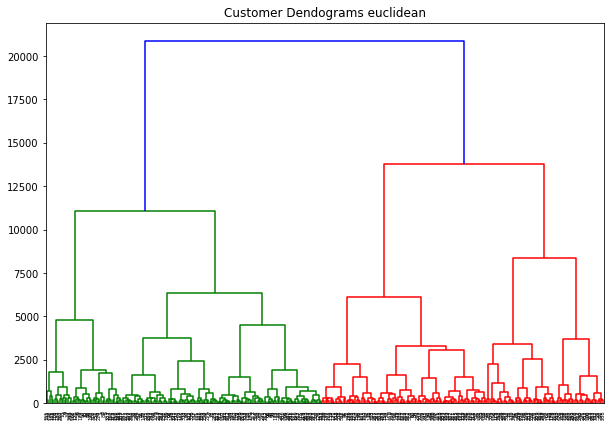

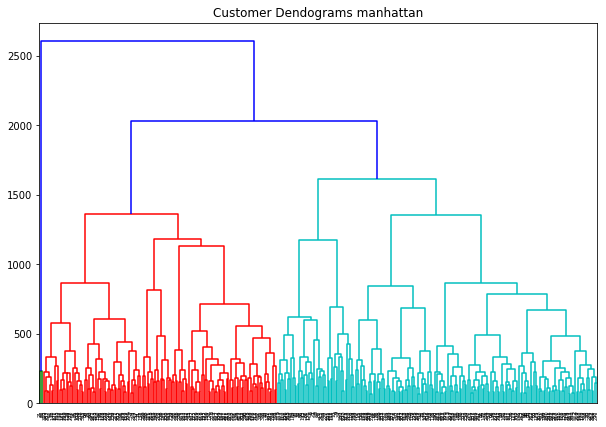

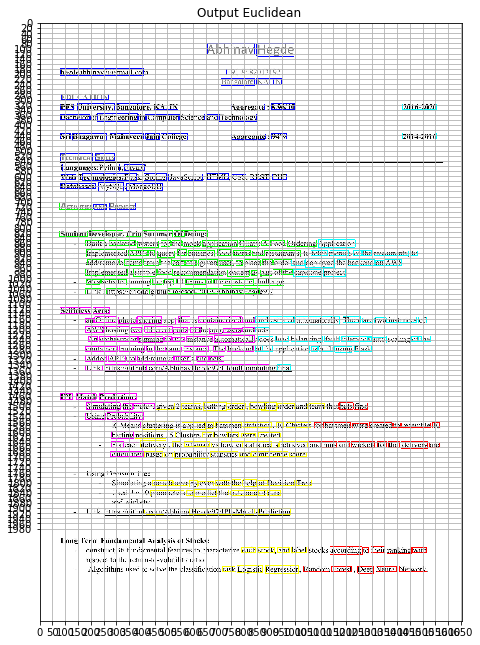

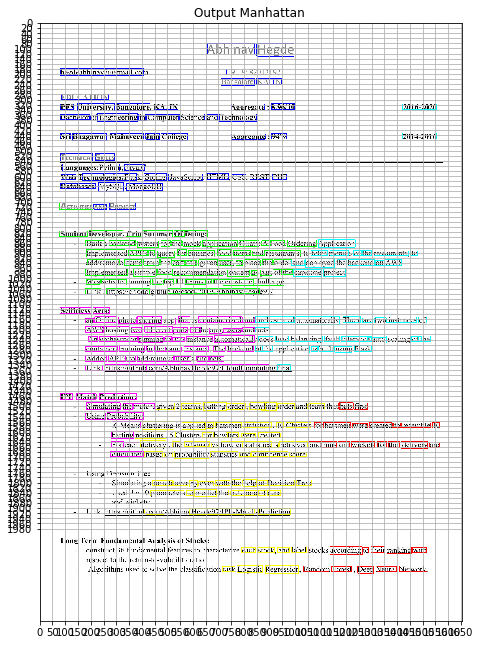

In [24]:
text_file = open(r"C:\Users\rames\OneDrive\Desktop\namma\FinalYear\EAST-master\tmp\output\output_0.txt", "r")
lines = text_file.readlines()
#print(len(lines))
#print(type(lines[0]))
text_file.close()

vals =[]
for line in lines:
    coords = line.split(",")
    coords[-1]=coords[-1].rstrip('\n')
    if line=='\n':
        continue
    vals.append(coords)
import numpy as np
X = np.array(vals)
img1 = cv2.imread(r"C:\Users\rames\OneDrive\Desktop\namma\FinalYear\EAST-master\tmp\images\output_0.jpg")

from sklearn.cluster import AgglomerativeClustering

import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms euclidean")
dend = shc.dendrogram(shc.linkage(X, method='ward'))

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms manhattan")
dend = shc.dendrogram(shc.linkage(X, method='average'))

model1 = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
model1.fit(X)
labels1 = model1.labels_
#print("Euclidean:\t",labels1)

model2 = AgglomerativeClustering(n_clusters=7, affinity='manhattan', linkage='average')
model2.fit(X)
labels2 = model2.labels_
#print("Manhattan:\t", labels2)


img1_plot = img1.copy()
ctr = 0

# Moving over the results and display on the image
for row in X:
    if(labels1[ctr]==0):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[4]), int(row[5])),(0, 0, 255), 2)
    if(labels1[ctr]==1):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[4]), int(row[5])),(255, 0, 0), 2)
    if(labels1[ctr]==2):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[4]), int(row[5])),(0, 255, 0), 2)
    if(labels1[ctr]==3):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[4]), int(row[5])),(255, 255, 0), 2)
    if(labels1[ctr]==4):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[4]), int(row[5])),(0, 255, 255), 2)
    if(labels1[ctr]==5):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[4]), int(row[5])),(255, 0, 255), 2)
    if(labels1[ctr]==6):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[4]), int(row[5])),(255, 255, 255), 2)
    ctr+=1
    
fig= plt.figure(figsize=(15,11))
ax = fig.gca()
ax.set_xticks(np.arange(0, 1800, 50))
ax.set_yticks(np.arange(0, 2000, 20))
plt.imshow(img1_plot)
plt.title('Output Euclidean ')
plt.grid()
plt.show()

ctr = 0

for row in X:
    if(labels1[ctr]==0):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[4]), int(row[5])),(0, 0, 255), 2)
    if(labels1[ctr]==1):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[4]), int(row[5])),(255, 0, 0), 2)
    if(labels1[ctr]==2):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[4]), int(row[5])),(0, 255, 0), 2)
    if(labels1[ctr]==3):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[4]), int(row[5])),(255, 255, 0), 2)
    if(labels1[ctr]==4):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[4]), int(row[5])),(0, 255, 255), 2)
    if(labels1[ctr]==5):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[4]), int(row[5])),(255, 0, 255), 2)
    if(labels1[ctr]==6):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[4]), int(row[5])),(255, 255, 255), 2)
    ctr+=1
 
    
fig= plt.figure(figsize=(15,11))
ax = fig.gca()
ax.set_xticks(np.arange(0, 1800, 50))
ax.set_yticks(np.arange(0, 2000, 20))
plt.imshow(img1_plot)
plt.title('Output Manhattan ')
plt.grid()
plt.show()

In [25]:
X

array([['83', '278', '267', ..., '299', '83', '302'],
       ['79', '179', '405', ..., '206', '80', '213'],
       ['498', '1040', '860', ..., '1060', '498', '1066'],
       ...,
       ['601', '2055', '626', ..., '2073', '602', '2074'],
       ['488', '1228', '514', ..., '1248', '489', '1249'],
       ['417', '1263', '442', ..., '1285', '417', '1285']], dtype='<U4')

In [17]:
import cv2
import imutils
import numpy as np
import random

# capture image
path = r"C:\Users\rames\OneDrive\Desktop\namma\FinalYear\EAST-master\tmp\images\output_0.jpg"
image = cv2.imread(path)
image = imutils.resize(image, width=500)
resize_factor = 1


blur = cv2.GaussianBlur(image, (9, 9), 0)
cv2.imshow('Blurred', blur)
cv2.waitKey()

# this was the golden line that made it better
# edged = cv2.Canny(blur, 0, 150)
edged = cv2.Canny(blur, 0, 30)

cv2.imshow('Edged', edged)
cv2.waitKey()

# edged = cv2.Canny(image, 0, 150)
# cv2.imshow("Edged", edged)
# cv2.waitKey()

# dilated = cv2.dilate(edged, np.ones((15, 15)))
dilated = cv2.dilate(edged, np.ones((10, 10)), iterations=1)
cv2.imshow('Dilated', dilated)
cv2.waitKey()


def _contour_approx_bad(contour, *args, **kwargs):
    """
    Approximate contour and discard non rectangular contours
    :returns: True if rectangle else False
    """
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 2 * perimeter, True)

    return len(approx) == 4


contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i, contour in enumerate(contours):
    if not _contour_approx_bad(contour):
        rect = cv2.boundingRect(contour)
        x, y, w, h = [r*resize_factor for r in rect]
        b, g = random.sample(range(0, 255), 2)
        cv2.rectangle(image, (x,y), ((x+w), (y+h)), (b, g, 255), 3)
        # self.crop(name=str(i), **{'start': (x,y), 'end': ((x+w), (y+h))})

cv2.imshow('Final Image', image)
cv2.waitKey()
cv2.imwrite('tobecropped.png', image) 

True

In [37]:
import cv2
import numpy as np
import cv2
import imutils
import numpy as np
import random

# Load image, grayscale, Gaussian blur, Otsu's threshold
image = cv2.imread( r"C:\Users\rames\OneDrive\Desktop\namma\FinalYear\EAST-master\tmp\01FB16ECS012_Copy_of_Resume_-_Abhinav_Hegde-1.jpg")
image = imutils.resize(image, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7,7), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Create rectangular structuring element and dilate
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
dilate = cv2.dilate(thresh, kernel, iterations=1)

# Find contours and draw rectangle
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)

cv2.imshow('thresh', thresh)
cv2.imshow('dilate', dilate)
cv2.imshow('image', image)
cv2.waitKey()

-1

In [12]:
text_file = open(r"D:\College\FinalYearCapstone\StandardResume\coordinates\01FB16ECS012_Copy_of_Resume_-_Abhinav_Hegde.txt", "r")
lines = text_file.readlines()
text_file.close()
img = cv2.imread( r"D:\College\FinalYearCapstone\StandardResume\coordinates\01FB16ECS012_Copy_of_Resume_-_Abhinav_Hegde.jpg")
vals =[]
for line in lines:
    coords = line.split(",")
    coords[-1]=coords[-1].rstrip('\n')
    if line=='\n':
        continue
    coords = list(map(int, coords)) 
    vals.append(coords)
vals

[[983, 3036, 1462, 3031, 1462, 3061, 984, 3066],
 [550, 2632, 933, 2639, 932, 2671, 549, 2664],
 [453, 1038, 881, 1033, 881, 1062, 454, 1067],
 [955, 2641, 1184, 2638, 1185, 2665, 955, 2668],
 [82, 273, 264, 272, 264, 302, 82, 303],
 [651, 80, 836, 78, 836, 120, 651, 122],
 [959, 2601, 1105, 2605, 1104, 2628, 959, 2624],
 [500, 1900, 739, 1896, 740, 1925, 501, 1928],
 [176, 928, 328, 926, 329, 950, 176, 951],
 [413, 2807, 551, 2805, 551, 2830, 414, 2833],
 [784, 176, 946, 173, 947, 203, 785, 206],
 [707, 1224, 824, 1222, 825, 1251, 708, 1254],
 [266, 1526, 388, 1524, 388, 1549, 267, 1551],
 [126, 551, 277, 555, 277, 583, 125, 578],
 [193, 2124, 331, 2127, 330, 2154, 193, 2151],
 [631, 2054, 774, 2052, 775, 2075, 632, 2077],
 [248, 2009, 409, 2013, 408, 2040, 247, 2036],
 [824, 3040, 937, 3041, 937, 3064, 824, 3063],
 [292, 1786, 409, 1790, 408, 1816, 291, 1812],
 [247, 1447, 373, 1450, 372, 1478, 246, 1475],
 [719, 355, 845, 357, 844, 383, 719, 381],
 [182, 964, 331, 961, 331, 988, 183

In [13]:
for val in vals:
    #get width |x1-x2| and height |y1-y4|
    height = abs(val[0]-val[2])
    width = abs(val[1]-val[7])
    #print(height, width)
    val.append(width)
    val.append(height)
vals

[[983, 3036, 1462, 3031, 1462, 3061, 984, 3066, 30, 479],
 [550, 2632, 933, 2639, 932, 2671, 549, 2664, 32, 383],
 [453, 1038, 881, 1033, 881, 1062, 454, 1067, 29, 428],
 [955, 2641, 1184, 2638, 1185, 2665, 955, 2668, 27, 229],
 [82, 273, 264, 272, 264, 302, 82, 303, 30, 182],
 [651, 80, 836, 78, 836, 120, 651, 122, 42, 185],
 [959, 2601, 1105, 2605, 1104, 2628, 959, 2624, 23, 146],
 [500, 1900, 739, 1896, 740, 1925, 501, 1928, 28, 239],
 [176, 928, 328, 926, 329, 950, 176, 951, 23, 152],
 [413, 2807, 551, 2805, 551, 2830, 414, 2833, 26, 138],
 [784, 176, 946, 173, 947, 203, 785, 206, 30, 162],
 [707, 1224, 824, 1222, 825, 1251, 708, 1254, 30, 117],
 [266, 1526, 388, 1524, 388, 1549, 267, 1551, 25, 122],
 [126, 551, 277, 555, 277, 583, 125, 578, 27, 151],
 [193, 2124, 331, 2127, 330, 2154, 193, 2151, 27, 138],
 [631, 2054, 774, 2052, 775, 2075, 632, 2077, 23, 143],
 [248, 2009, 409, 2013, 408, 2040, 247, 2036, 27, 161],
 [824, 3040, 937, 3041, 937, 3064, 824, 3063, 23, 113],
 [292, 178

In [14]:
bboxes = []
for bbox in vals:
    x = [bbox[i] for i in [0,1,8,9]]
    bboxes.append(x)
bboxes

[[983, 3036, 30, 479],
 [550, 2632, 32, 383],
 [453, 1038, 29, 428],
 [955, 2641, 27, 229],
 [82, 273, 30, 182],
 [651, 80, 42, 185],
 [959, 2601, 23, 146],
 [500, 1900, 28, 239],
 [176, 928, 23, 152],
 [413, 2807, 26, 138],
 [784, 176, 30, 162],
 [707, 1224, 30, 117],
 [266, 1526, 25, 122],
 [126, 551, 27, 151],
 [193, 2124, 27, 138],
 [631, 2054, 23, 143],
 [248, 2009, 27, 161],
 [824, 3040, 23, 113],
 [292, 1786, 26, 117],
 [247, 1447, 28, 126],
 [719, 355, 26, 126],
 [182, 964, 26, 149],
 [196, 889, 28, 137],
 [1146, 2488, 25, 122],
 [126, 434, 25, 143],
 [648, 1001, 22, 159],
 [186, 2566, 27, 115],
 [519, 1336, 24, 199],
 [343, 2054, 24, 142],
 [1008, 1153, 23, 154],
 [1416, 433, 26, 139],
 [371, 2925, 25, 94],
 [80, 1112, 26, 116],
 [147, 315, 24, 130],
 [1391, 1154, 21, 96],
 [856, 78, 49, 139],
 [438, 1831, 24, 140],
 [744, 319, 25, 140],
 [403, 1563, 25, 115],
 [178, 2056, 23, 108],
 [385, 2091, 24, 154],
 [75, 177, 27, 159],
 [80, 629, 21, 139],
 [274, 435, 23, 137],
 [1092, 

In [15]:
bboxes_list = list()
heights = list()
height_tot = 0
for bbox in bboxes:
    x, y, w, h = bbox
    bboxes_list.append([x, y, x + w, y + h])  # Create list of bounding boxes, with each bbox containing the left-top and right-bottom coordinates
    heights.append(h)
    height_tot+=h
heights = sorted(heights)  # Sort heights
mean_height = height_tot/len(bboxes)
#median_height = heights[len(heights) / 2] / 2  # Find half of the median height

In [16]:
def grouper(iterable, interval):
    prev = None
    group = []
    for item in iterable:
        if not prev or abs(item[1] - prev[1]) <= interval:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

In [25]:
bboxes_list1 = sorted(bboxes_list, key=lambda k: k[1])  # Sort the bounding boxes based on y1 coordinate ( y of the left-top coordinate )
#print(bboxes_list1)
combined_bboxes = grouper(bboxes_list1, mean_height)  # Group the bounding boxes
combined_bboxes
line_box = []
for group in combined_bboxes:
    x_min = min(group, key=lambda k: k[0])[0]  # Find min of x1
    x_max = max(group, key=lambda k: k[2])[2]  # Find max of x2
    y_min = min(group, key=lambda k: k[1])[1]  # Find min of y1
    y_max = max(group, key=lambda k: k[3])[3]  # Find max of y2
    temp = [x_min,y_min,x_max,y_max]
    line_box.append(temp)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)


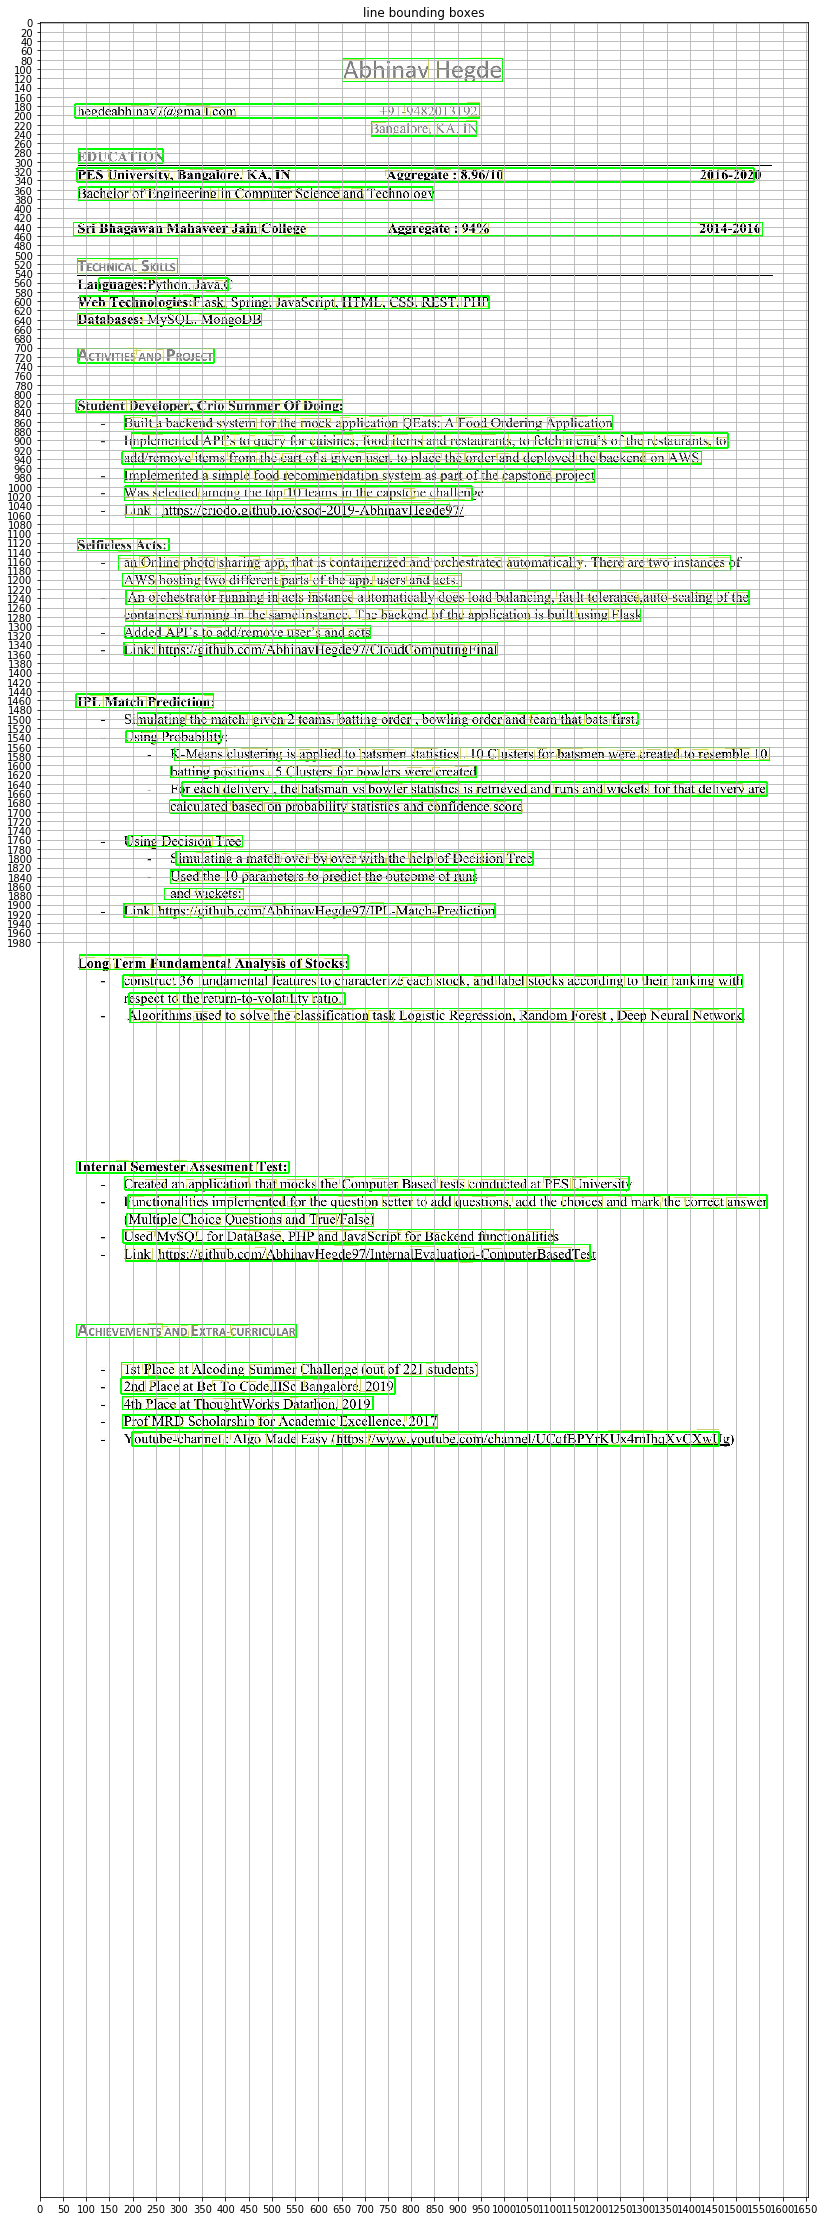

In [26]:
fig= plt.figure(figsize=(60,40))
ax = fig.gca()
ax.set_xticks(np.arange(0, 1800, 50))
ax.set_yticks(np.arange(0, 2000, 20))
plt.imshow(img)
plt.title('line bounding boxes')
plt.grid()
plt.show()

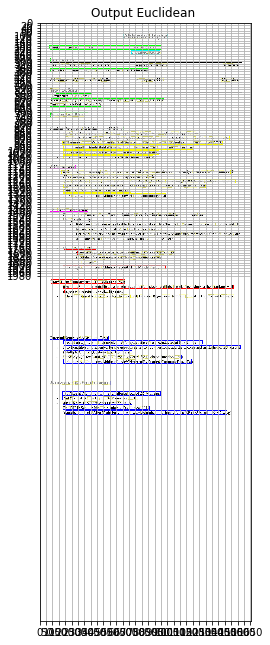

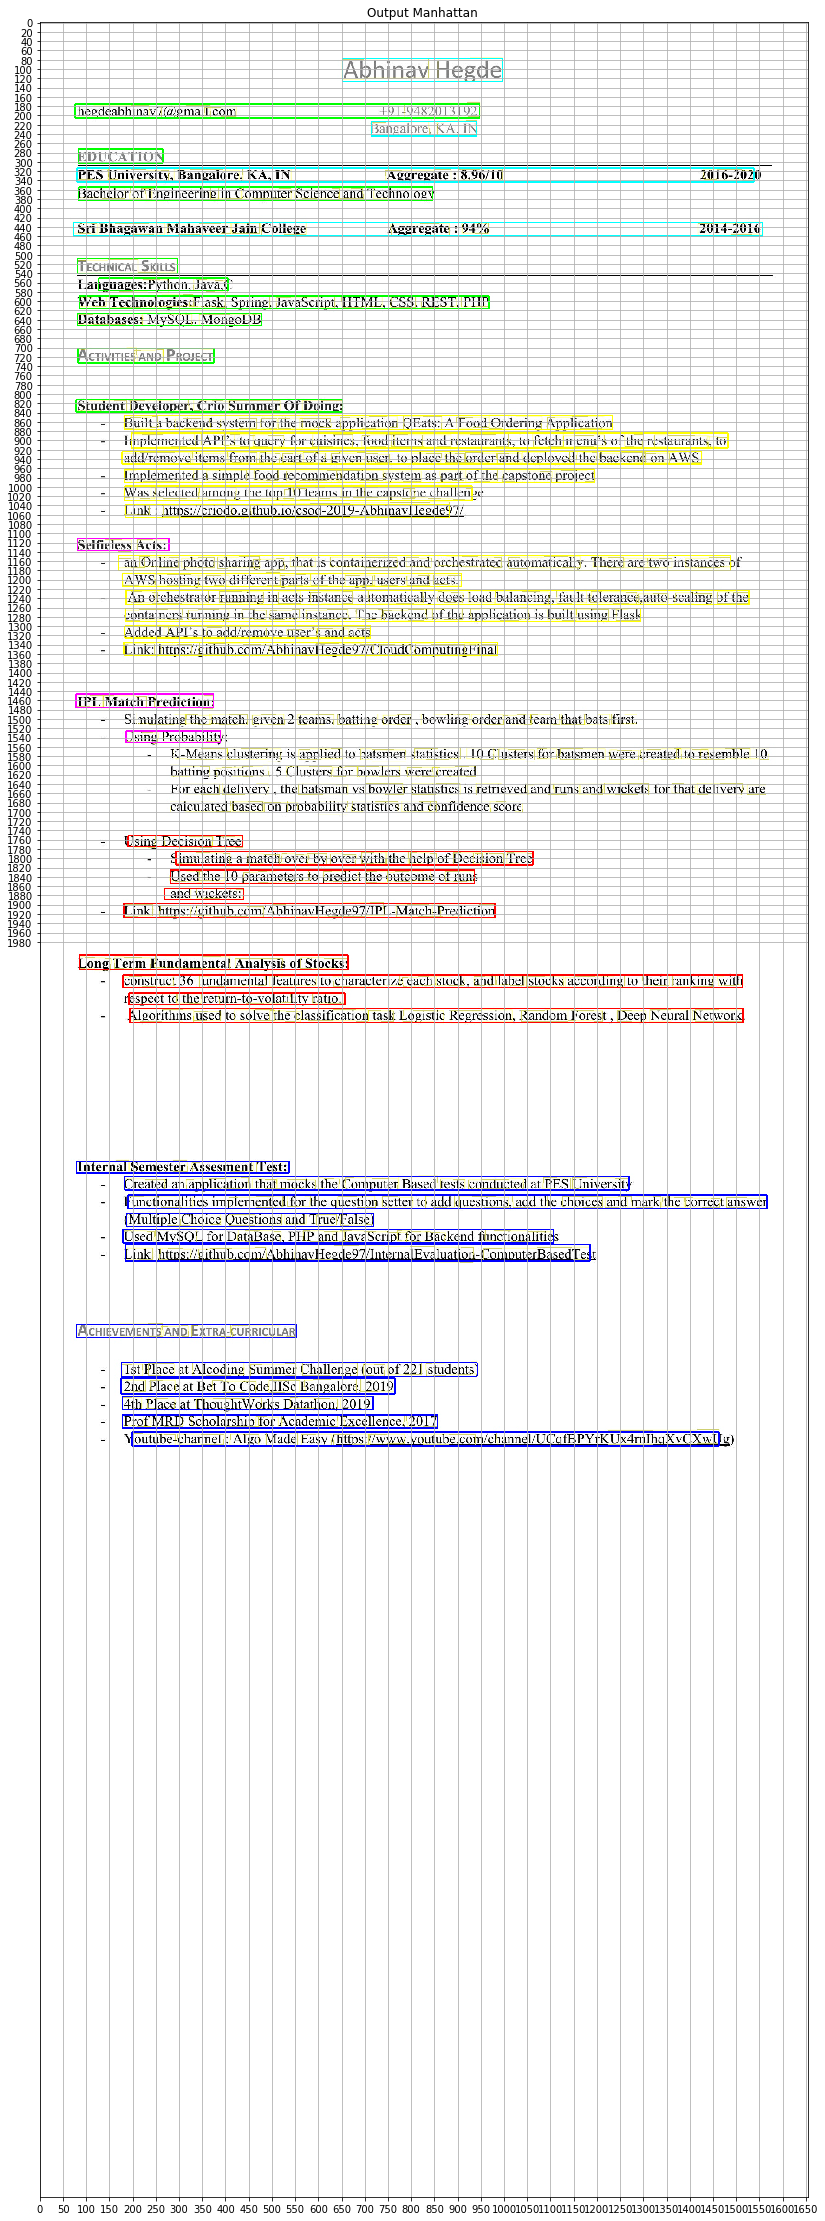

In [31]:
import scipy.cluster.hierarchy as shc

lines_centroid =[]
for line in line_box:
    temp =[(line[0]+line[2])/2,(line[1]+line[3])/2]
    lines_centroid.append(temp)
X = np.array(line_box)
X1 = np.array(lines_centroid)
'''plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms euclidean")
dend = shc.dendrogram(shc.linkage(, method='ward'))

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms manhattan")
dend = shc.dendrogram(shc.linkage(X, method='average'))
'''
model1 = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
model1.fit(X1)
labels1 = model1.labels_
#print("Euclidean:\t",labels1)

model2 = AgglomerativeClustering(n_clusters=7, affinity='manhattan', linkage='average')
model2.fit(X1)
labels2 = model2.labels_
#print("Manhattan:\t", labels2)


img1_plot = img.copy()
ctr = 0

# Moving over the results and display on the image
for row in X:
    if(labels1[ctr]==0):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[2]), int(row[3])),(0, 0, 255), 2)
    if(labels1[ctr]==1):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[2]), int(row[3])),(255, 0, 0), 2)
    if(labels1[ctr]==2):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[2]), int(row[3])),(0, 255, 0), 2)
    if(labels1[ctr]==3):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[2]), int(row[3])),(255, 255, 0), 2)
    if(labels1[ctr]==4):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[2]), int(row[3])),(0, 255, 255), 2)
    if(labels1[ctr]==5):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[2]), int(row[3])),(255, 0, 255), 2)
    if(labels1[ctr]==6):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[2]), int(row[3])),(255, 255, 255), 2)
    ctr+=1
    
fig= plt.figure(figsize=(15,11))
ax = fig.gca()
ax.set_xticks(np.arange(0, 1800, 50))
ax.set_yticks(np.arange(0, 2000, 20))
plt.imshow(img1_plot)
plt.title('Output Euclidean ')
plt.grid()
plt.show()

ctr = 0

for row in X:
    if(labels1[ctr]==0):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[2]), int(row[3])),(0, 0, 255), 2)
    if(labels1[ctr]==1):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[2]), int(row[3])),(255, 0, 0), 2)
    if(labels1[ctr]==2):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[2]), int(row[3])),(0, 255, 0), 2)
    if(labels1[ctr]==3):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[2]), int(row[3])),(255, 255, 0), 2)
    if(labels1[ctr]==4):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[2]), int(row[3])),(0, 255, 255), 2)
    if(labels1[ctr]==5):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[2]), int(row[3])),(255, 0, 255), 2)
    if(labels1[ctr]==6):
        cv2.rectangle(img1_plot, (int(row[0]), int(row[1])), (int(row[2]), int(row[3])),(255, 255, 255), 2)
    ctr+=1
 
    
fig= plt.figure(figsize=(60,40))
ax = fig.gca()
ax.set_xticks(np.arange(0, 1800, 50))
ax.set_yticks(np.arange(0, 2000, 20))
plt.imshow(img1_plot)
plt.title('Output Manhattan ')
plt.grid()
plt.show()

Text(0, 0.5, 'Feature 1')

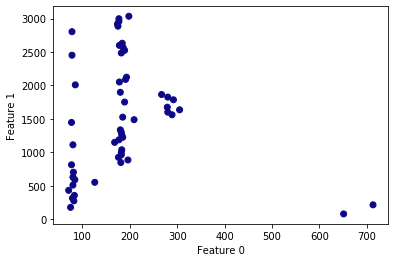

In [29]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# cluster the data into five clusters
dbscan = DBSCAN(eps=0.123, min_samples = 2)
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
